# Week 2 notebook

-0.09090909090909091 0.0 0.0
0.9090909090909091 0.0 0.0
<rebound.Orbit instance, a=2.1568627450980395 e=0.5363636363636364 inc=0.0 Omega=0.0 omega=0.0 f=0.0> 18.97655132331586


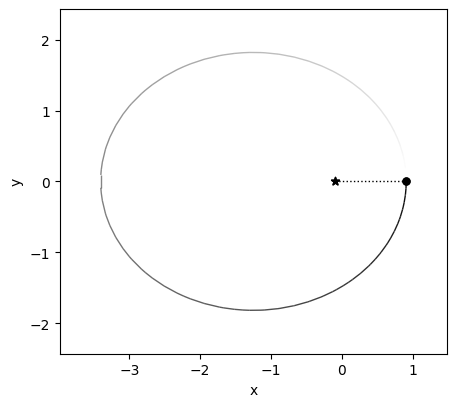

In [1]:
#%matplotlib widget
import matplotlib.pyplot as plt
import rebound
import time
import numpy as np
plt.close()

# set up the simulation
sim = rebound.Simulation()
sim.add(m=1)
sim.add(m=0.1, x=1, vy=1.3)
sim.move_to_com()

# plot the positions and instantaneous orbit
op = rebound.OrbitPlot(sim, periastron=True)

# output info about the particles and the orbit
for p in sim.particles:
    print(p.x, p.y, p.z)
for o in sim.orbits(): 
    print(o, o.P)

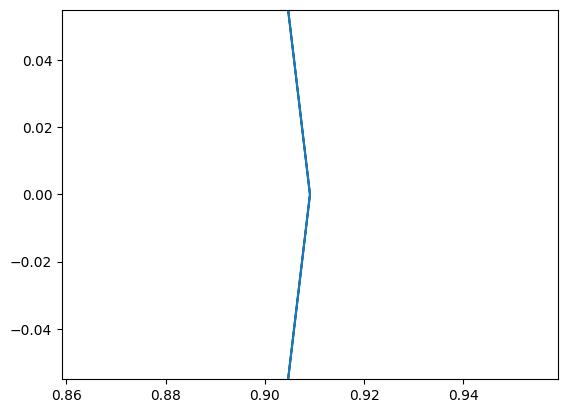

In [2]:
p_orb = sim.orbits()[0].P

xvec = [sim.particles[1].x]
yvec = [sim.particles[1].y]
op2, = plt.plot(xvec, yvec)

for i in range(200):
    # integrate for 1% of the orbit
    op.sim.integrate(sim.t + 0.01*p_orb)

    # store the trajectory of particle 2 (index 1)
    xvec.append(sim.particles[1].x)
    yvec.append(sim.particles[1].y)

    # update the plot to animate it
    op.update() #updateLimits=True) 
    op2.set_data((xvec,yvec)) 
    time.sleep(0.001)
    op.fig.canvas.draw()

# 1.

a)

First, let's solve for the locations of the Lagrangian points. We know the positions of L4 and L5 from the textbook:

In [31]:
mu2 = 0.2

L4_x, L4_y = 0.5 - mu2, +np.sqrt(3)/2
L5_x, L5_y = 0.5 - mu2, -np.sqrt(3)/2

Now, we solve the locations of L1, L2 and L3:

In [32]:
from scipy.optimize import fsolve

def f(x, mu1, mu2):
    term1 = mu1 * (-1 / (x + mu2)**2 + x + mu2)
    term2 = mu2 * (-1 / (x - mu1)**2 + x - mu1)
    return term1 + term2

mu2 = 0.2 
mu1 = 1 - mu2

def func(x):
    return f(x, mu1, mu2)

initial_guesses = [-1, 0, 1.2]  

roots = [fsolve(func, guess)[0] for guess in initial_guesses]

unique_roots = np.unique(np.real(roots))
_, L1_x, L2_x   = unique_roots

print("Roots:", unique_roots)

Roots: [-1.384905    0.42463187  1.27104869]


/var/folders/v2/wt2pd74d4sj0yh8b1j9bp2p80000gn/T/ipykernel_691/557267185.py:16: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  roots = [fsolve(func, guess)[0] for guess in initial_guesses]


The function to 'inverse solve' is different for L3:

In [33]:
def f_L3(x, mu1, mu2):
    term1 = mu1 * (-1 / (x + mu2)**2 - x - mu2)
    term2 = mu2 * (-1 / (x - mu1)**2 - x + mu1)
    return term1 + term2

mu2 = 0.2 
mu1 = 1 - mu2

COM_x, COM_y = 0, 0 # COM frame
mu1_x, mu1_y = COM_x-mu2, COM_y
mu2_x, mu2_y = COM_x+(1-mu2), COM_y

def func_L3(x):
    return f_L3(x, mu1, mu2)

initial_guesses = [-1, 0, 1.2]  

roots = [fsolve(func_L3, guess)[0] for guess in initial_guesses]

unique_roots = np.unique(np.real(roots))
L3_x, _, _   = unique_roots

print("Roots:", unique_roots)

Roots: [-1.08283946  0.40173867  1.6172582 ]


/var/folders/v2/wt2pd74d4sj0yh8b1j9bp2p80000gn/T/ipykernel_691/2968889047.py:18: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  roots = [fsolve(func_L3, guess)[0] for guess in initial_guesses]


In [34]:
L1_y, L2_y, L3_y = 0, 0, 0

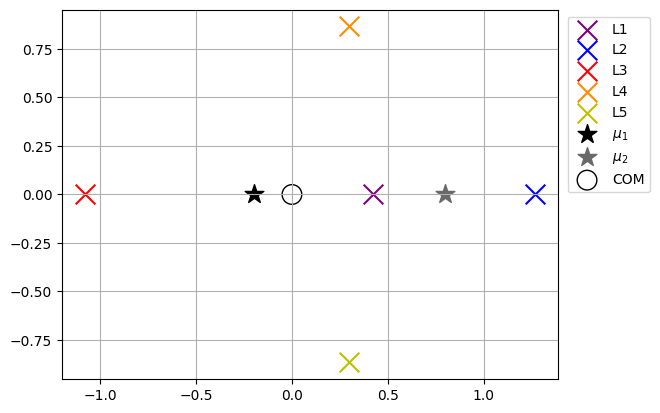

In [35]:
plt.close('all')
plt.scatter(L1_x, L1_y, color='purple', s=200, marker='x', label='L1')
plt.scatter(L2_x, L2_y, color='blue', s=200, marker='x', label='L2')
plt.scatter(L3_x, L3_y, color='r', s=200, marker='x', label='L3')
plt.scatter(L4_x, L4_y, color='darkorange', s=200, marker='x', label='L4')
plt.scatter(L5_x, L5_y, color='y', marker='x', s=200, label='L5')

plt.scatter(mu1_x, mu1_y, color='black', s=200, marker='*', label=r'$\mu_1$')
plt.scatter(mu2_x, mu2_y, color='dimgrey', s=200, marker='*', label=r'$\mu_2$')
plt.scatter(0, 0, facecolors='none',  s=200, edgecolors='k', label='COM')

plt.legend(bbox_to_anchor=(1.2,1))
plt.grid()

Calculate the Jacobi constant (since we'll be working on the Lagrangian points, ignore the $\dot{x}_i^2$ terms):

In [36]:
def r1(x, y, mu2):
    return np.sqrt((x+mu2)**2 + y**2)

def r2(x, y, mu1):
    return np.sqrt((x-mu1)**2 + y**2)

def Cj(n, x, y, mu1, mu2):
    return (n**2)*(x**2 + y**2) + 2*(mu1/r1(x, y, mu2) + mu2/r2(x, y, mu1)) 

We want to invert the function so as to solve for $r$ as a function of $C_j$:

In [37]:
def f_Cj(x, y, n, mu1, mu2, CJ):
    term1 = n**2 * (x**2 + y**2)
    term2 = 2 * (mu1 / np.sqrt((x + mu2)**2 + y**2) + mu2 / np.sqrt((x - mu1)**2 + y**2))
    return term1 + term2 - CJ

In [38]:
def solve_contours(xrange, yrange, n, mu1, mu2, CJ_value):
    
    X, Y = np.meshgrid(xrange, yrange)
    
    Z = f_Cj(X, Y, n, mu1, mu2, CJ_value)

    return X, Y, Z

In [39]:
x_range = np.linspace(-2, 2, 500)  
y_range = np.linspace(-2, 2, 500)  

n=1

X1, Y1, Z1 = solve_contours(x_range, y_range, n, mu1, mu2, CJ_value=3.805)
X2, Y2, Z2 = solve_contours(x_range, y_range, n, mu1, mu2, CJ_value=3.552)
X3, Y3, Z3 = solve_contours(x_range, y_range, n, mu1, mu2, CJ_value=3.197)

Fig 3.7

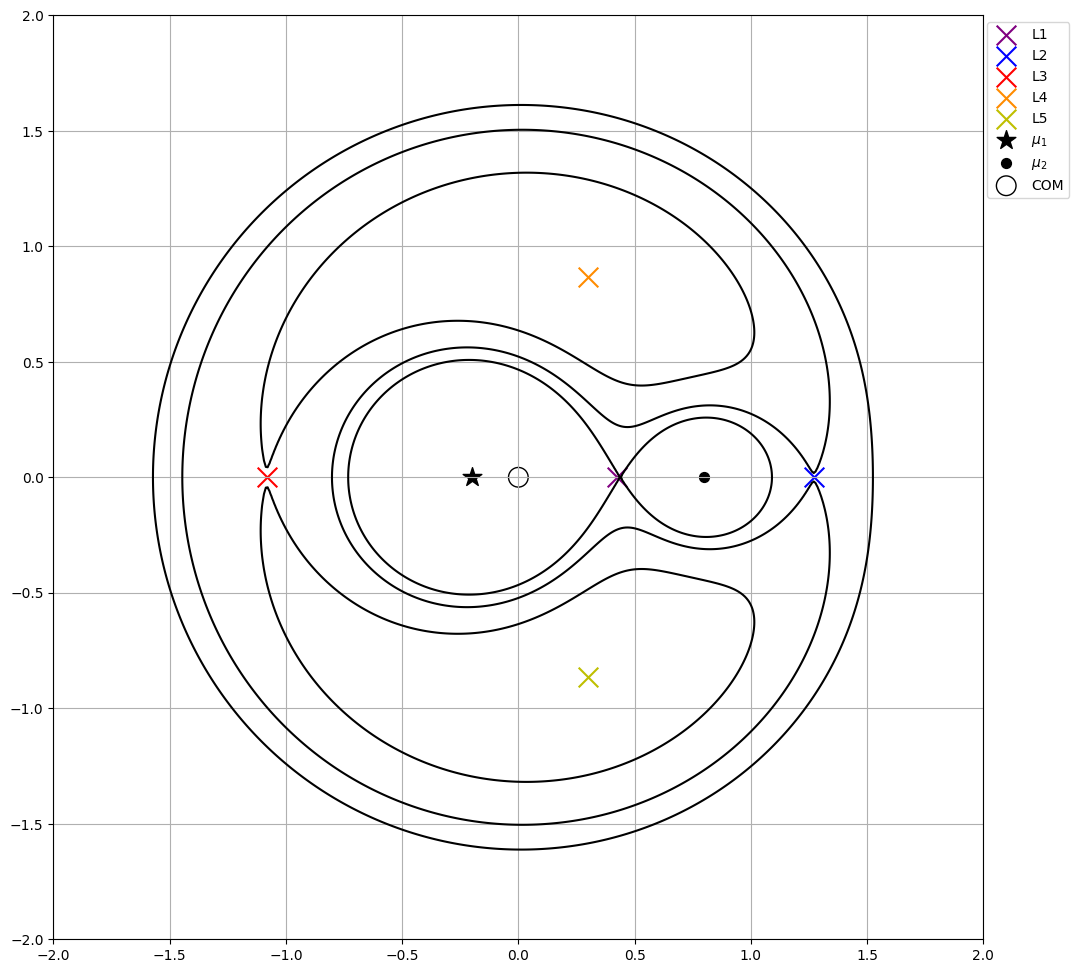

In [40]:
plt.close('all')
plt.figure(figsize=(12, 12))

contour1 = plt.contour(X1, Y1, Z1, levels=[0], colors='k')  
contour2 = plt.contour(X2, Y2, Z2, levels=[0], colors='k')  
contour3 = plt.contour(X3, Y3, Z3, levels=[0], colors='k')  



plt.scatter(L1_x, L1_y, color='purple', marker='x', s=200, label='L1')
plt.scatter(L2_x, L2_y, color='blue', marker='x', s=200, label='L2')
plt.scatter(L3_x, L3_y, color='r', marker='x', s=200, label='L3')
plt.scatter(L4_x, L4_y, color='darkorange', marker='x', s=200, label='L4')
plt.scatter(L5_x, L5_y, color='y', marker='x', s=200, label='L5')

plt.scatter(mu1_x, mu1_y, color='k', marker='*', s=200, label=r'$\mu_1$')
plt.scatter(mu2_x, mu2_y, color='k', marker='.', s=200, label=r'$\mu_2$')
plt.scatter(0, 0, facecolors='none',  edgecolors='k', s=200, label='COM')

plt.legend(bbox_to_anchor=(1.1,1))
plt.grid()

debug

In [61]:
# Cj at L1:
CJ_L1 = Cj(n=1.0, x=L1_x, y=L1_y, mu1=1-0.2, mu2=0.2)
CJ_L1

np.float64(3.8074415425018917)

In [62]:
# Cj at L2:
CJ_L2 = Cj(n=1.0, x=L2_x, y=L2_y, mu1=1-0.2, mu2=0.2)
CJ_L2

np.float64(3.5523933328511763)

In [63]:
# Cj at L3:
CJ_L3 = Cj(n=1.0, x=L3_x, y=L3_y, mu1=1-0.2, mu2=0.2)
CJ_L3

np.float64(3.19732042100598)

Fig 3.9

In [28]:
# ---- solve L1 and L2 ----

def f(x, mu1, mu2):
    term1 = mu1 * (-1 / (x + mu2)**2 + x + mu2)
    term2 = mu2 * (-1 / (x - mu1)**2 + x - mu1)
    return term1 + term2

mu2 = 0.01
mu1 = 1 - mu2

COM_x, COM_y = 0, 0 # COM frame
mu1_x, mu1_y = COM_x-mu2, COM_y
mu2_x, mu2_y = COM_x+(1-mu2), COM_y

def func(x):
    return f(x, mu1, mu2)

initial_guesses = [-1, 0, 1.2]  

roots = [fsolve(func, guess)[0] for guess in initial_guesses]

unique_roots = np.unique(np.real(roots))
_, L1_x, L2_x   = unique_roots

print('L1 =', L1_x)
print('L2 =', L2_x)


# ---- solve L3 ----


def f_L3(x, mu1, mu2):
    term1 = mu1 * (-1 / (x + mu2)**2 - x - mu2)
    term2 = mu2 * (-1 / (x - mu1)**2 - x + mu1)
    return term1 + term2

def func_L3(x):
    return f_L3(x, mu1, mu2)

initial_guesses = [-1, 0, 1.2]  

roots = [fsolve(func_L3, guess)[0] for guess in initial_guesses]

unique_roots = np.unique(np.real(roots))[0]
L3_x = unique_roots

print('L3 =', L3_x)

L1 = 0.8244281815903937
L2 = 1.1467650421238045
L3 = -1.0041666119974995


/var/folders/v2/wt2pd74d4sj0yh8b1j9bp2p80000gn/T/ipykernel_691/2814388829.py:20: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  roots = [fsolve(func, guess)[0] for guess in initial_guesses]
/var/folders/v2/wt2pd74d4sj0yh8b1j9bp2p80000gn/T/ipykernel_691/2814388829.py:20: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  roots = [fsolve(func, guess)[0] for guess in initial_guesses]
/var/folders/v2/wt2pd74d4sj0yh8b1j9bp2p80000gn/T/ipykernel_691/2814388829.py:42: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  roots = [fsolve(func_L3, guess)[0] for guess in initial_guesses]
/var/folders/v2/wt2pd74d4sj0yh8b1j9bp2p80000gn/T/ipykernel_691/2814388829.py:42: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement f

In [29]:
x_range = np.linspace(-2, 2, 500)  
y_range = np.linspace(-2, 2, 500)  

n=1

X1, Y1, Z1 = solve_contours(x_range, y_range, n, mu1, mu2, CJ_value=Cj(n=1.0, x=L1_x, y=0, mu1=mu1, mu2=mu2)) # L1
X2, Y2, Z2 = solve_contours(x_range, y_range, n, mu1, mu2, CJ_value=Cj(n=1.0, x=L2_x, y=0, mu1=mu1, mu2=mu2)) # L2
X3, Y3, Z3 = solve_contours(x_range, y_range, n, mu1, mu2, CJ_value=Cj(n=1.0, x=L3_x, y=0, mu1=mu1, mu2=mu2)) # L3

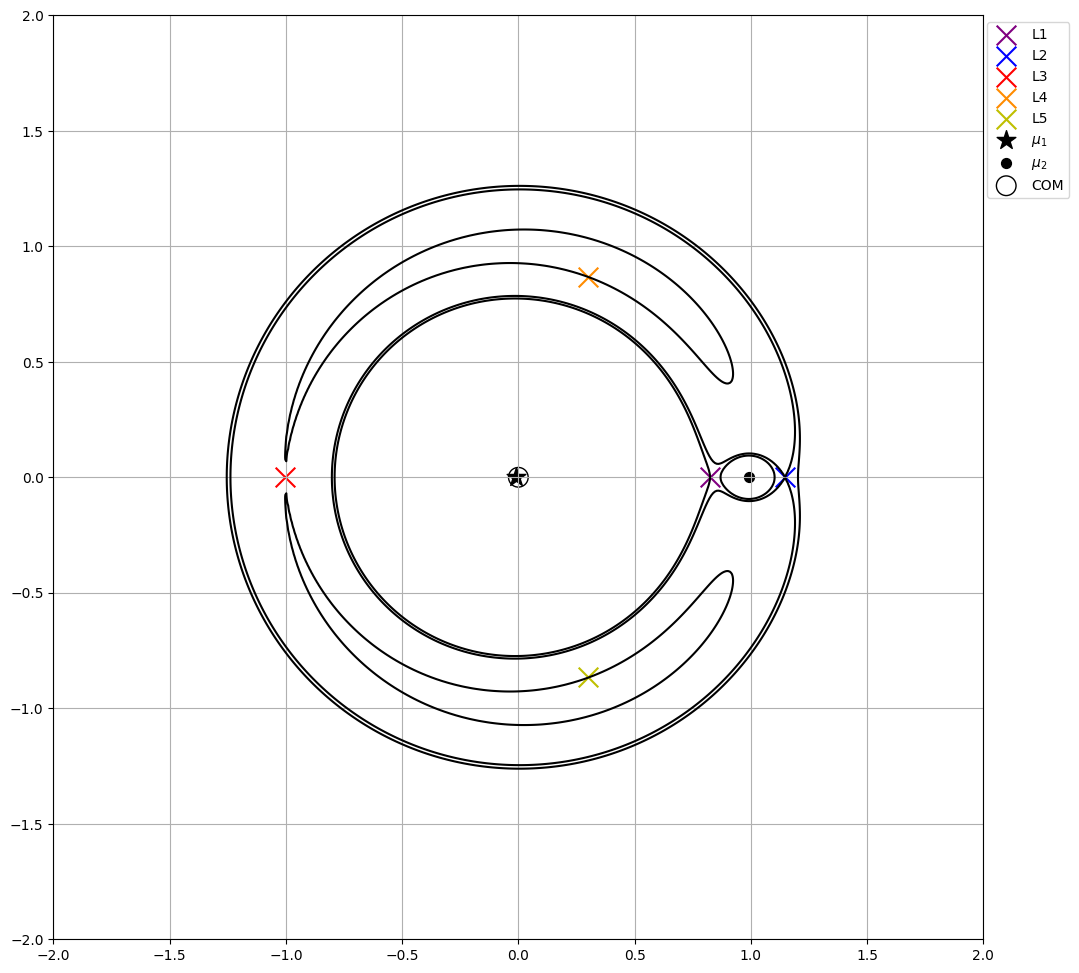

In [30]:
plt.close('all')
plt.figure(figsize=(12, 12))

contour1 = plt.contour(X1, Y1, Z1, levels=[0], colors='k')  
contour2 = plt.contour(X2, Y2, Z2, levels=[0], colors='k')  
contour3 = plt.contour(X3, Y3, Z3, levels=[0], colors='k')  



plt.scatter(L1_x, L1_y, color='purple', marker='x', s=200, label='L1')
plt.scatter(L2_x, L2_y, color='blue', marker='x', s=200, label='L2')
plt.scatter(L3_x, L3_y, color='r', marker='x', s=200, label='L3')
plt.scatter(L4_x, L4_y, color='darkorange', marker='x', s=200, label='L4')
plt.scatter(L5_x, L5_y, color='y', marker='x', s=200, label='L5')

plt.scatter(mu1_x, mu1_y, color='k', marker='*', s=200, label=r'$\mu_1$')
plt.scatter(mu2_x, mu2_y, color='black', marker='.', s=200, label=r'$\mu_2$')
plt.scatter(0, 0, facecolors='none',  edgecolors='k', s=200, label='COM')

plt.legend(bbox_to_anchor=(1.1,1))
plt.grid()

b)

The first thing we can do is check that we are moving to the corotating frame correctly. Let's consider two masses in a circular orbit. In the corotating frame, they should look still:

-0.001 0.0 0.0
0.999 0.0 0.0
<rebound.Orbit instance, a=1.0 e=0.0 inc=0.0 Omega=0.0 omega=0.0 f=0.0>
6.283185307179586


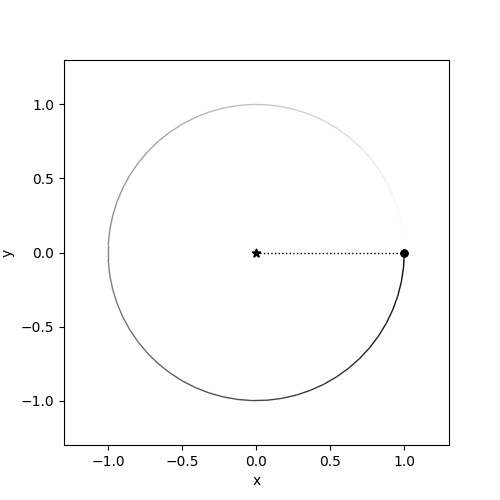

In [69]:
#%matplotlib widget

# set up parameters for star #2
mu2 = .001

# set up parameters for star #1
mu1 = 1 - mu2 

# set up parameters for third body
mu3 = .0001


# set up the simulation
sim = rebound.Simulation()
sim.add(m=mu1)                            # first body
sim.add(m=mu2, a=1, e=0)                  # second body
#sim.add(m=mu3, x=0.5-mu2, y=np.sqrt(3)/2, vx=0, vy=0) # third body
sim.move_to_com()

# plot the positions and instantaneous orbit
op = rebound.OrbitPlot(sim, periastron=True)

# output info about the particles and the orbit
for p in sim.particles:
    print(p.x, p.y, p.z)
for o in sim.orbits(): 
    print(o)
    print(o.P)

In [70]:
p_orb = sim.orbits()[0].P

Noutputs = 200
times = np.linspace(0, 2*p_orb, Noutputs)

n = 2*np.pi/o.P # mean motion
tau = 0 # time of pericentre passage

M = np.zeros(Noutputs)

# particle 1
xvec1 = np.zeros(Noutputs)
yvec1 = np.zeros(Noutputs)

vxvec1 = np.zeros(Noutputs)
vyvec1 = np.zeros(Noutputs)

xvec1[0] = sim.particles[0].x
yvec1[0] = sim.particles[0].y
op1, = plt.plot(xvec1[:1], yvec1[:1])

# particle 2; in the still reference frame 

vxvec2 = np.zeros(Noutputs)
vyvec2 = np.zeros(Noutputs)

xvec2 = np.zeros(Noutputs)
yvec2 = np.zeros(Noutputs)

xvec2[0] = sim.particles[1].x
yvec2[0] = sim.particles[1].y

op2, = plt.plot(xvec2[:1], yvec2[:1])


for i, t in enumerate(times):
    # integrate the next part of the orbit
    op.sim.integrate(t)

    M[i] = n*(t - tau)
    
    # store the trajectory of particle 1 (index 0)
    xvec1[i] = sim.particles[0].x
    yvec1[i] = sim.particles[0].y

    vxvec1[i] = sim.particles[0].vx
    vyvec1[i] = sim.particles[0].vy

    # store the trajectory of particle 2 (index 1)
    xvec2[i] = sim.particles[1].x
    yvec2[i] = sim.particles[1].y

    vxvec2[i] = sim.particles[1].vx
    vyvec2[i] = sim.particles[1].vy


    # update the plot to animate it
    op.update() # can use updateLimits=True if you want to dynamically update the plot limits
    
    op1.set_data((xvec1[:i+1],yvec1[:i+1])) # plot the trajectory so far
    op2.set_data((xvec2[:i+1],yvec2[:i+1])) 
    
    time.sleep(0.001)
    op.fig.canvas.draw()

Move to corotating frame with rotation matrix:

In [5]:
def from_com_to_corot(x, y, M):
    
    x1 = x*np.cos(M) + y*np.sin(M)
    y1 = -x*np.sin(M) + y*np.cos(M)
    
    return x1, y1

In [72]:
xvec1_1, yvec1_1 = from_com_to_corot(x=xvec1, y=yvec1, M=M)
xvec2_1, yvec2_1 = from_com_to_corot(x=xvec2, y=yvec2, M=M)

(-0.5, 0.5)

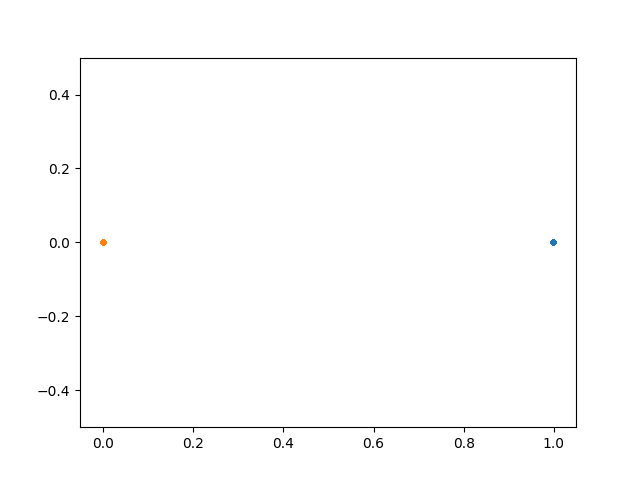

In [73]:
plt.close('all')
plt.plot(xvec2_1, yvec2_1, '.')
plt.plot(xvec1_1, yvec1_1, '.')

plt.ylim(-0.5, 0.5)

Indeed, both masses stay at the same place in the corotating frame!

Now, let's add a third body. It has to have zero velocity in the corotating frame, but what velocity is that in the COM frame, which is the one needed for REBOUND?

Fig 3.16a)

-0.001 0.0 0.0
0.999 0.0 0.0
0.5045 0.8725254037844385 0.0
<rebound.Orbit instance, a=1.0 e=0.0 inc=0.0 Omega=0.0 omega=0.0 f=0.0>
6.283185307179586
<rebound.Orbit instance, a=1.0324780184891897 e=0.0238248613360004 inc=0.0 Omega=0.0 omega=1.046555495828751 f=0.0>
6.591755493039285


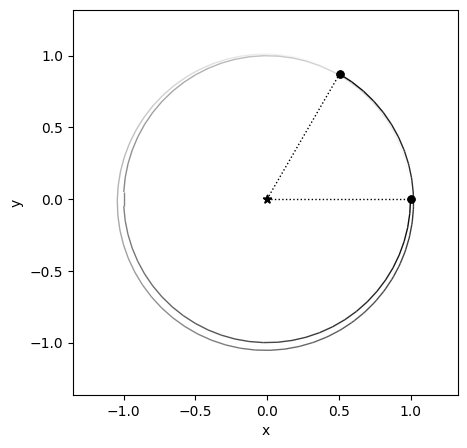

In [2]:
#%matplotlib widget

# set up parameters for star #2
mu2 = .001

# set up parameters for star #1
mu1 = 1 - mu2 

# set up parameters for third body
mu3 = 0
x3 = 0.5-mu2 + 0.0065
y3 = np.sqrt(3)/2 + 0.0065
vx3 = -y3 # such that velocity = 0 in corotating frame
vy3 = x3  # such that velocity = 0 in corotating frame

# set up the simulation
sim = rebound.Simulation()
sim.add(m=mu1)                            # first body
sim.add(m=mu2, a=1, e=0)                  # second body
sim.add(m=mu3, x=x3, y=y3, vx=vx3, vy=vy3) # third body
sim.move_to_com()

# plot the positions and instantaneous orbit
op = rebound.OrbitPlot(sim, periastron=True)

# output info about the particles and the orbit
for p in sim.particles:
    print(p.x, p.y, p.z)
for o in sim.orbits(): 
    print(o)
    print(o.P)

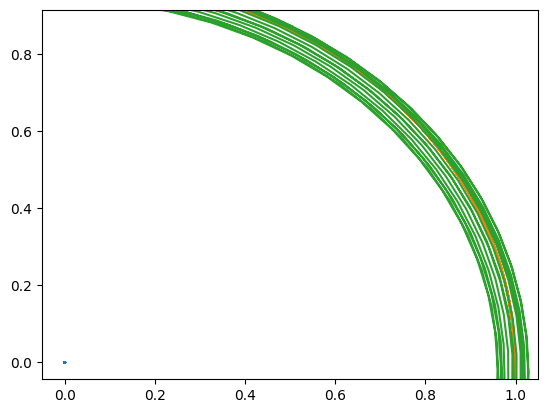

In [3]:
p_orb = sim.orbits()[0].P

Noutputs = 1000
times = np.linspace(0, 15*p_orb, Noutputs)

n = 2*np.pi/p_orb # mean motion
tau = 0 # time of pericentre passage

M = np.zeros(Noutputs)

# particle 1
xvec1 = np.zeros(Noutputs)
yvec1 = np.zeros(Noutputs)

vxvec1 = np.zeros(Noutputs)
vyvec1 = np.zeros(Noutputs)

xvec1[0] = sim.particles[0].x
yvec1[0] = sim.particles[0].y
op1, = plt.plot(xvec1[:1], yvec1[:1])

# particle 2; in the still reference frame 

vxvec2 = np.zeros(Noutputs)
vyvec2 = np.zeros(Noutputs)

xvec2 = np.zeros(Noutputs)
yvec2 = np.zeros(Noutputs)

xvec2[0] = sim.particles[1].x
yvec2[0] = sim.particles[1].y
op2, = plt.plot(xvec2[:1], yvec2[:1])


# particle 3; in the still reference frame 

vxvec3 = np.zeros(Noutputs)
vyvec3 = np.zeros(Noutputs)

xvec3 = np.zeros(Noutputs)
yvec3 = np.zeros(Noutputs)

xvec3[0] = sim.particles[2].x
yvec3[0] = sim.particles[2].y
op3, = plt.plot(xvec3[:1], yvec3[:1])

# store other parameters

avec = np.zeros(Noutputs)
evec = np.zeros(Noutputs)

r1vec = np.zeros(Noutputs)
r2vec = np.zeros(Noutputs)


for i, t in enumerate(times):
    # integrate the next part of the orbit
    op.sim.integrate(t)

    M[i] = n*(t - tau)
    
    # store the trajectory of particle 1 (index 0)
    xvec1[i] = sim.particles[0].x
    yvec1[i] = sim.particles[0].y

    vxvec1[i] = sim.particles[0].vx
    vyvec1[i] = sim.particles[0].vy

    # store the trajectory of particle 2 (index 1)
    xvec2[i] = sim.particles[1].x
    yvec2[i] = sim.particles[1].y

    vxvec2[i] = sim.particles[1].vx
    vyvec2[i] = sim.particles[1].vy

    # store the trajectory of particle 3 (index 2)
    xvec3[i] = sim.particles[2].x
    yvec3[i] = sim.particles[2].y

    vxvec3[i] = sim.particles[2].vx
    vyvec3[i] = sim.particles[2].vy

    # store other parameters

    a[i] = sim.orbits()[1].a
    e[i] = sim.orbits()[1].e


    # update the plot to animate it
    op.update() # can use updateLimits=True if you want to dynamically update the plot limits
    
    op1.set_data((xvec1[:i+1],yvec1[:i+1])) # plot the trajectory so far
    op2.set_data((xvec2[:i+1],yvec2[:i+1])) 
    op3.set_data((xvec3[:i+1],yvec3[:i+1])) 
    
    time.sleep(0.001)
    op.fig.canvas.draw()

In [6]:
xvec1_corot, yvec1_corot = from_com_to_corot(x=xvec1, y=yvec1, M=M)
xvec2_corot, yvec2_corot = from_com_to_corot(x=xvec2, y=yvec2, M=M)
xvec3_corot, yvec3_corot = from_com_to_corot(x=xvec3, y=yvec3, M=M)

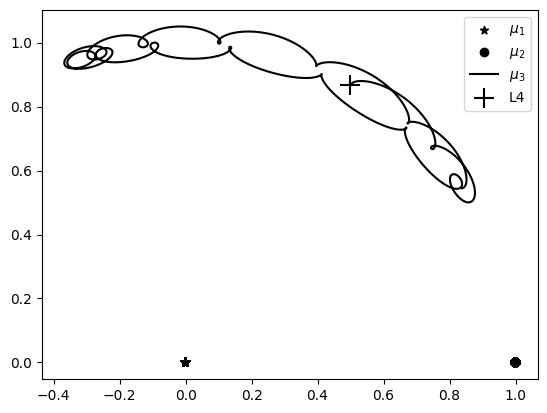

In [7]:
plt.close('all')
plt.scatter(xvec1_corot, yvec1_corot, marker='*', color='k', label=r'$\mu_1$')
plt.scatter(xvec2_corot, yvec2_corot, marker='o', color='k', label=r'$\mu_2$')
plt.plot(xvec3_corot, yvec3_corot, color='k', label=r'$\mu_3$')
plt.scatter(0.5-mu2, np.sqrt(3)/2, marker='+', s=200, color='k', label='L4')

plt.legend()

Fig 3.16b)

-0.001 0.0 0.0
0.999 0.0 0.0
0.506 0.8740254037844386 0.0
<rebound.Orbit instance, a=1.0 e=0.0 inc=0.0 Omega=0.0 omega=0.0 f=0.0>
6.283185307179586
<rebound.Orbit instance, a=1.041253420807936 e=0.03008346344352223 inc=0.0 Omega=0.0 omega=1.0460131582273107 f=0.0>
6.675972363317439


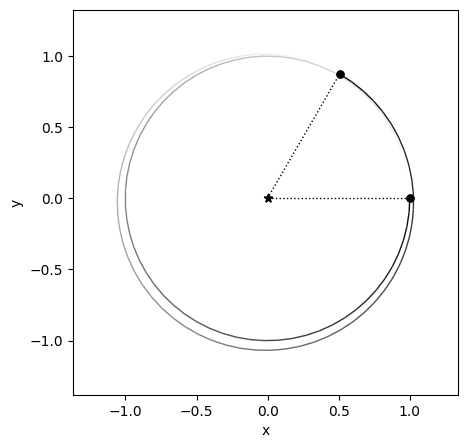

In [8]:
#%matplotlib widget

# set up parameters for star #2
mu2 = .001

# set up parameters for star #1
mu1 = 1 - mu2 

# set up parameters for third body
mu3 = 0
x3 = 0.5-mu2 + 0.008
y3 = np.sqrt(3)/2 + 0.008
vx3 = -y3 # such that velocity = 0 in corotating frame
vy3 = x3  # such that velocity = 0 in corotating frame

# set up the simulation
sim = rebound.Simulation()
sim.add(m=mu1)                            # first body
sim.add(m=mu2, a=1, e=0)                  # second body
sim.add(m=mu3, x=x3, y=y3, vx=vx3, vy=vy3) # third body
sim.move_to_com()

# plot the positions and instantaneous orbit
op = rebound.OrbitPlot(sim, periastron=True)

# output info about the particles and the orbit
for p in sim.particles:
    print(p.x, p.y, p.z)
for o in sim.orbits(): 
    print(o)
    print(o.P)

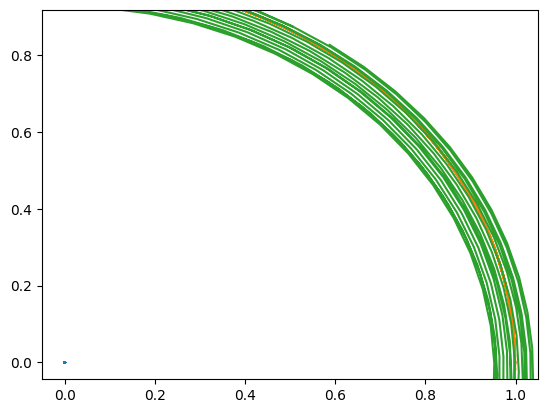

In [9]:
p_orb = sim.orbits()[0].P

Noutputs = 1000
times = np.linspace(0, 15*p_orb, Noutputs)

n = 2*np.pi/p_orb # mean motion
tau = 0 # time of pericentre passage

M = np.zeros(Noutputs)

# particle 1
xvec1 = np.zeros(Noutputs)
yvec1 = np.zeros(Noutputs)

vxvec1 = np.zeros(Noutputs)
vyvec1 = np.zeros(Noutputs)

xvec1[0] = sim.particles[0].x
yvec1[0] = sim.particles[0].y
op1, = plt.plot(xvec1[:1], yvec1[:1])

# particle 2; in the still reference frame 

vxvec2 = np.zeros(Noutputs)
vyvec2 = np.zeros(Noutputs)

xvec2 = np.zeros(Noutputs)
yvec2 = np.zeros(Noutputs)

xvec2[0] = sim.particles[1].x
yvec2[0] = sim.particles[1].y
op2, = plt.plot(xvec2[:1], yvec2[:1])


# particle 3; in the still reference frame 

vxvec3 = np.zeros(Noutputs)
vyvec3 = np.zeros(Noutputs)

xvec3 = np.zeros(Noutputs)
yvec3 = np.zeros(Noutputs)

xvec3[0] = sim.particles[2].x
yvec3[0] = sim.particles[2].y
op3, = plt.plot(xvec3[:1], yvec3[:1])


for i, t in enumerate(times):
    # integrate the next part of the orbit
    op.sim.integrate(t)

    M[i] = n*(t - tau)
    
    # store the trajectory of particle 1 (index 0)
    xvec1[i] = sim.particles[0].x
    yvec1[i] = sim.particles[0].y

    vxvec1[i] = sim.particles[0].vx
    vyvec1[i] = sim.particles[0].vy

    # store the trajectory of particle 2 (index 1)
    xvec2[i] = sim.particles[1].x
    yvec2[i] = sim.particles[1].y

    vxvec2[i] = sim.particles[1].vx
    vyvec2[i] = sim.particles[1].vy

    # store the trajectory of particle 3 (index 2)
    xvec3[i] = sim.particles[2].x
    yvec3[i] = sim.particles[2].y

    vxvec3[i] = sim.particles[2].vx
    vyvec3[i] = sim.particles[2].vy


    # update the plot to animate it
    op.update() # can use updateLimits=True if you want to dynamically update the plot limits
    
    op1.set_data((xvec1[:i+1],yvec1[:i+1])) # plot the trajectory so far
    op2.set_data((xvec2[:i+1],yvec2[:i+1])) 
    op3.set_data((xvec3[:i+1],yvec3[:i+1])) 
    
    time.sleep(0.001)
    op.fig.canvas.draw()

In [10]:
xvec1_corot, yvec1_corot = from_com_to_corot(x=xvec1, y=yvec1, M=M)
xvec2_corot, yvec2_corot = from_com_to_corot(x=xvec2, y=yvec2, M=M)
xvec3_corot, yvec3_corot = from_com_to_corot(x=xvec3, y=yvec3, M=M)

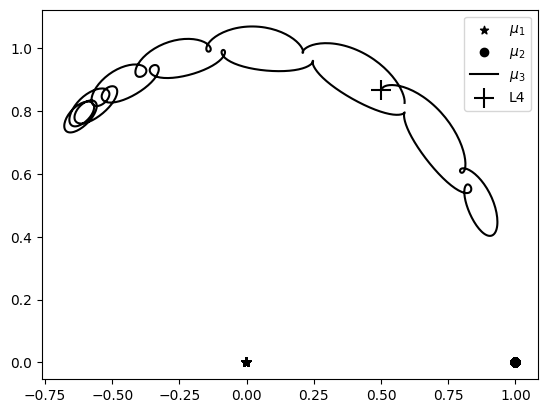

In [11]:
plt.close('all')
plt.scatter(xvec1_corot, yvec1_corot, marker='*', color='k', label=r'$\mu_1$')
plt.scatter(xvec2_corot, yvec2_corot, marker='o', color='k', label=r'$\mu_2$')
plt.plot(xvec3_corot, yvec3_corot, color='k', label=r'$\mu_3$')
plt.scatter(0.5-mu2, np.sqrt(3)/2, marker='+', s=200, color='k', label='L4')

plt.legend()

3.17a)

-0.000953875 0.0 0.0
0.999046125 0.0 0.0
-0.977633875 0.0 0.0
<rebound.Orbit instance, a=1.0 e=0.0 inc=0.0 Omega=0.0 omega=0.0 f=0.0>
6.283185307179586
<rebound.Orbit instance, a=1.0345312469298453 e=0.05499821498741428 inc=0.0 Omega=0.0 omega=3.141592653589793 f=0.0>
6.6114282213752


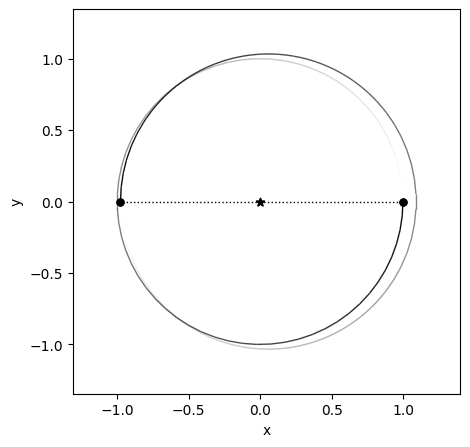

In [12]:
#%matplotlib widget

# set up parameters for star #2
mu2 = 0.000953875

# set up parameters for star #1
mu1 = 1 - mu2 

# set up parameters for third body
mu3 = 0
x3 = -0.97668
y3 = 0
vx3 = -y3 # such that velocity = 0 in corotating frame
vy3 = -0.06118 + x3  # such that velocity = -0.06118 in corotating frame

# set up the simulation
sim = rebound.Simulation()
sim.add(m=mu1)                            # first body
sim.add(m=mu2, a=1, e=0)                  # second body
sim.add(m=mu3, x=x3, y=y3, vx=vx3, vy=vy3) # third body
sim.move_to_com()

# plot the positions and instantaneous orbit
op = rebound.OrbitPlot(sim, periastron=True)

# output info about the particles and the orbit
for p in sim.particles:
    print(p.x, p.y, p.z)
for o in sim.orbits(): 
    print(o)
    print(o.P)

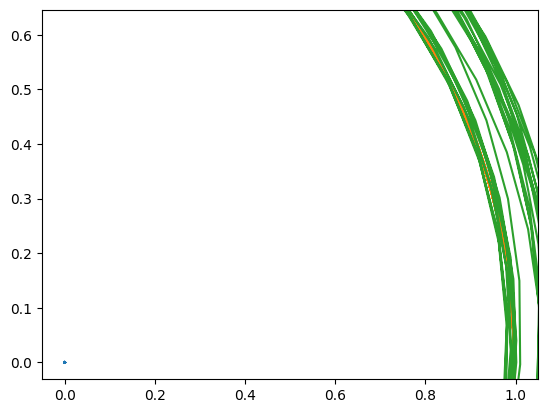

In [22]:
p_orb = sim.orbits()[0].P

Noutputs = 1000
times = np.linspace(0, 25*p_orb, Noutputs)

n = 2*np.pi/p_orb # mean motion
tau = 0 # time of pericentre passage

M = np.zeros(Noutputs)

# particle 1
xvec1 = np.zeros(Noutputs)
yvec1 = np.zeros(Noutputs)

vxvec1 = np.zeros(Noutputs)
vyvec1 = np.zeros(Noutputs)

xvec1[0] = sim.particles[0].x
yvec1[0] = sim.particles[0].y
op1, = plt.plot(xvec1[:1], yvec1[:1])

# particle 2; in the still reference frame 

vxvec2 = np.zeros(Noutputs)
vyvec2 = np.zeros(Noutputs)

xvec2 = np.zeros(Noutputs)
yvec2 = np.zeros(Noutputs)

xvec2[0] = sim.particles[1].x
yvec2[0] = sim.particles[1].y
op2, = plt.plot(xvec2[:1], yvec2[:1])


# particle 3; in the still reference frame 

vxvec3 = np.zeros(Noutputs)
vyvec3 = np.zeros(Noutputs)

xvec3 = np.zeros(Noutputs)
yvec3 = np.zeros(Noutputs)

xvec3[0] = sim.particles[2].x
yvec3[0] = sim.particles[2].y
op3, = plt.plot(xvec3[:1], yvec3[:1])


for i, t in enumerate(times):
    # integrate the next part of the orbit
    op.sim.integrate(t)

    M[i] = n*(t - tau)
    
    # store the trajectory of particle 1 (index 0)
    xvec1[i] = sim.particles[0].x
    yvec1[i] = sim.particles[0].y

    vxvec1[i] = sim.particles[0].vx
    vyvec1[i] = sim.particles[0].vy

    # store the trajectory of particle 2 (index 1)
    xvec2[i] = sim.particles[1].x
    yvec2[i] = sim.particles[1].y

    vxvec2[i] = sim.particles[1].vx
    vyvec2[i] = sim.particles[1].vy

    # store the trajectory of particle 3 (index 2)
    xvec3[i] = sim.particles[2].x
    yvec3[i] = sim.particles[2].y

    vxvec3[i] = sim.particles[2].vx
    vyvec3[i] = sim.particles[2].vy


    # update the plot to animate it
    op.update() # can use updateLimits=True if you want to dynamically update the plot limits
    
    op1.set_data((xvec1[:i+1],yvec1[:i+1])) # plot the trajectory so far
    op2.set_data((xvec2[:i+1],yvec2[:i+1])) 
    op3.set_data((xvec3[:i+1],yvec3[:i+1])) 
    
    time.sleep(0.001)
    op.fig.canvas.draw()

In [23]:
xvec1_corot, yvec1_corot = from_com_to_corot(x=xvec1, y=yvec1, M=M)
xvec2_corot, yvec2_corot = from_com_to_corot(x=xvec2, y=yvec2, M=M)
xvec3_corot, yvec3_corot = from_com_to_corot(x=xvec3, y=yvec3, M=M)

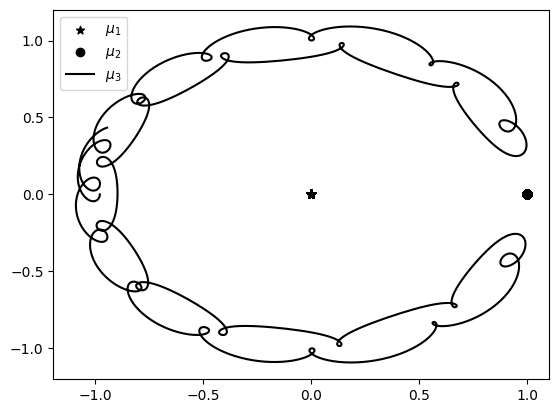

In [24]:
plt.close('all')
plt.scatter(xvec1_corot, yvec1_corot, marker='*', color='k', label=r'$\mu_1$')
plt.scatter(xvec2_corot, yvec2_corot, marker='o', color='k', label=r'$\mu_2$')
plt.plot(xvec3_corot, yvec3_corot, color='k', label=r'$\mu_3$')
#plt.scatter(0.5-mu2, np.sqrt(3)/2, marker='+', s=200, color='k', label='L4')

plt.legend()

3.17b)

-0.000953875 0.0 0.0
0.999046125 0.0 0.0
-1.028403875 0.0 0.0
<rebound.Orbit instance, a=1.0 e=0.0 inc=0.0 Omega=0.0 omega=0.0 f=0.0>
6.283185307179586
<rebound.Orbit instance, a=1.0325762305212527 e=0.004040723965867973 inc=0.0 Omega=0.0 omega=3.141592653589793 f=0.0>
6.592696053155844


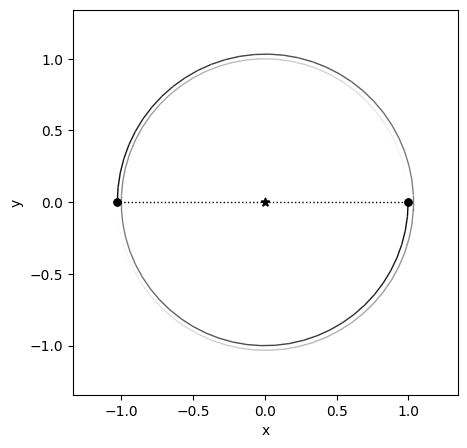

In [25]:
#%matplotlib widget

# set up parameters for star #2
mu2 = 0.000953875

# set up parameters for star #1
mu1 = 1 - mu2 

# set up parameters for third body
mu3 = 0
x3 = -1.02745
y3 = 0
vx3 = -y3 # such that velocity = 0 in corotating frame
vy3 = 0.04032 + x3  # such that velocity = -0.06118 in corotating frame

# set up the simulation
sim = rebound.Simulation()
sim.add(m=mu1)                            # first body
sim.add(m=mu2, a=1, e=0)                  # second body
sim.add(m=mu3, x=x3, y=y3, vx=vx3, vy=vy3) # third body
sim.move_to_com()

# plot the positions and instantaneous orbit
op = rebound.OrbitPlot(sim, periastron=True)

# output info about the particles and the orbit
for p in sim.particles:
    print(p.x, p.y, p.z)
for o in sim.orbits(): 
    print(o)
    print(o.P)

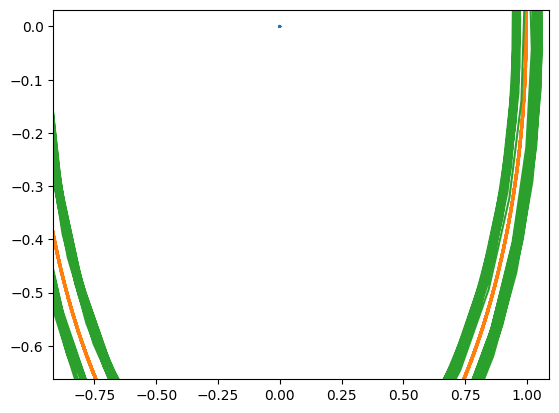

In [29]:
p_orb = sim.orbits()[0].P

Noutputs = 1000
times = np.linspace(0, 30*p_orb, Noutputs)

n = 2*np.pi/p_orb # mean motion
tau = 0 # time of pericentre passage

M = np.zeros(Noutputs)

# particle 1
xvec1 = np.zeros(Noutputs)
yvec1 = np.zeros(Noutputs)

vxvec1 = np.zeros(Noutputs)
vyvec1 = np.zeros(Noutputs)

xvec1[0] = sim.particles[0].x
yvec1[0] = sim.particles[0].y
op1, = plt.plot(xvec1[:1], yvec1[:1])

# particle 2; in the still reference frame 

vxvec2 = np.zeros(Noutputs)
vyvec2 = np.zeros(Noutputs)

xvec2 = np.zeros(Noutputs)
yvec2 = np.zeros(Noutputs)

xvec2[0] = sim.particles[1].x
yvec2[0] = sim.particles[1].y
op2, = plt.plot(xvec2[:1], yvec2[:1])


# particle 3; in the still reference frame 

vxvec3 = np.zeros(Noutputs)
vyvec3 = np.zeros(Noutputs)

xvec3 = np.zeros(Noutputs)
yvec3 = np.zeros(Noutputs)

xvec3[0] = sim.particles[2].x
yvec3[0] = sim.particles[2].y
op3, = plt.plot(xvec3[:1], yvec3[:1])


for i, t in enumerate(times):
    # integrate the next part of the orbit
    op.sim.integrate(t)

    M[i] = n*(t - tau)
    
    # store the trajectory of particle 1 (index 0)
    xvec1[i] = sim.particles[0].x
    yvec1[i] = sim.particles[0].y

    vxvec1[i] = sim.particles[0].vx
    vyvec1[i] = sim.particles[0].vy

    # store the trajectory of particle 2 (index 1)
    xvec2[i] = sim.particles[1].x
    yvec2[i] = sim.particles[1].y

    vxvec2[i] = sim.particles[1].vx
    vyvec2[i] = sim.particles[1].vy

    # store the trajectory of particle 3 (index 2)
    xvec3[i] = sim.particles[2].x
    yvec3[i] = sim.particles[2].y

    vxvec3[i] = sim.particles[2].vx
    vyvec3[i] = sim.particles[2].vy


    # update the plot to animate it
    op.update() # can use updateLimits=True if you want to dynamically update the plot limits
    
    op1.set_data((xvec1[:i+1],yvec1[:i+1])) # plot the trajectory so far
    op2.set_data((xvec2[:i+1],yvec2[:i+1])) 
    op3.set_data((xvec3[:i+1],yvec3[:i+1])) 
    
    time.sleep(0.001)
    op.fig.canvas.draw()

In [30]:
xvec1_corot, yvec1_corot = from_com_to_corot(x=xvec1, y=yvec1, M=M)
xvec2_corot, yvec2_corot = from_com_to_corot(x=xvec2, y=yvec2, M=M)
xvec3_corot, yvec3_corot = from_com_to_corot(x=xvec3, y=yvec3, M=M)

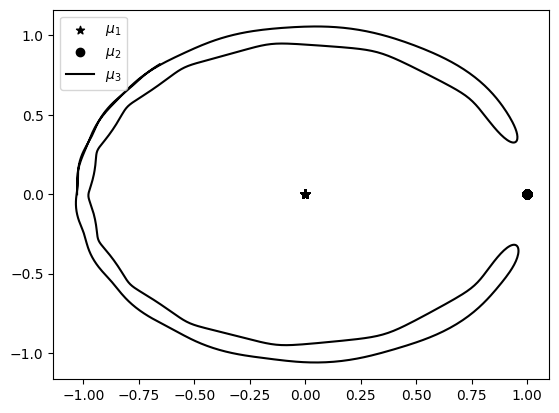

In [31]:
plt.close('all')
plt.scatter(xvec1_corot, yvec1_corot, marker='*', color='k', label=r'$\mu_1$')
plt.scatter(xvec2_corot, yvec2_corot, marker='o', color='k', label=r'$\mu_2$')
plt.plot(xvec3_corot, yvec3_corot, color='k', label=r'$\mu_3$')
#plt.scatter(0.5-mu2, np.sqrt(3)/2, marker='+', s=200, color='k', label='L4')

plt.legend()